In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score           

## R-Squared 계산 함수 정의
def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))
    
## 교차 검증을 수행하는 함수 정의
def cross_validation(model, X, y, n=5): 
    cv = KFold(n, shuffle=False)
    return cross_val_score(model, X, y, cv=cv).mean().round(4)

# 입력 변수 가중치
def plot_feature_weight(feature, weight, N=20):
    plt.figure(figsize=(8,int(N/2)))
    W = pd.DataFrame({'feature':feature[:N],'weight':weight[:N]})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)
    
def plot_reg_result(y_test, y_pred, N=50):
    y_test=y_test.ravel()
    y_pred=y_pred.ravel()
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_test, y_test-y_pred, s=5)


# 
# 1. Data Load

### 1-1) Data Import

In [2]:
data = pd.read_excel('CAPE.xlsx')
data.columns

Index(['NO', 'YEAR_MONTH', 'CB_TYPE', 'VSL_TYPE', 'TC_TYPE', 'CB_INDEX',
       'IND_12', 'IND_11', 'IND_10', 'IND_9', 'IND_8', 'IND_7', 'IND_6',
       'IND_5', 'IND_4', 'IND_3', 'IND_2', 'IND_1', 'M_12', 'M_11', 'M_10',
       'M_9', 'M_8', 'M_7', 'M_6', 'M_5', 'M_4', 'M_3', 'M_2', 'M_1',
       'M_AVG_CB3', 'M_AVG_CB6', 'M_AVG_CB12', 'MHIRE_12', 'MHIRE_11',
       'MHIRE_10', 'MHIRE_9', 'MHIRE_8', 'MHIRE_7', 'MHIRE_6', 'MHIRE_5',
       'MHIRE_4', 'MHIRE_3', 'MHIRE_2', 'MHIRE_1', 'MHIRE_AVG_CB3',
       'MHIRE_AVG_CB6', 'MHIRE_AVG_CB12', 'DAY_CB', 'DAY_HIRE'],
      dtype='object')

### 1-2) 컬럼명 변환

In [197]:
data.columns = ['No', 'Month', 'Line', 'Type', 'Owned',
                'BDI','IND-12', 'IND-11', 'IND-10', 'IND-9', 'IND-8', 'IND-7', 'IND-6', 'IND-5', 'IND-4', 'IND-3', 'IND-2', 'IND-1',  
                'M-12', 'M-11', 'M-10', 'M-9', 'M-8', 'M-7', 'M-6', 'M-5', 'M-4', 'M-3', 'M-2', 'M-1', 
                'M-AVG3', 'M-AVG6', 'M-AVG12',
                'TC-12', 'TC-11', 'TC-10', 'TC-9', 'TC-8', 'TC-7', 'TC-6', 'TC-5', 'TC-4', 'TC-3', 'TC-2', 'TC-1', 
                'TC-AVG3','TC-AVG6','TC-AVG12',
                'DAY_CB', 'DAY_HIRE']
data.shape

(196, 50)

In [198]:
data[:3]

,No,Month,Line,Type,Owned,BDI,IND-12,IND-11,IND-10,IND-9,...,TC-5,TC-4,TC-3,TC-2,TC-1,TC-AVG3,TC-AVG6,TC-AVG12,DAY_CB,DAY_HIRE
0,101,201501,TR,CAPE,OWNED,627,2171,1674,2766,1887,...,0,0,0,0,0,0,0,0,19858,0
1,109,201502,TR,CAPE,OWNED,612,1674,2766,1887,1508,...,0,0,0,0,0,0,0,0,17825,0
2,117,201503,TR,CAPE,OWNED,439,2766,1887,1508,1768,...,0,0,0,0,0,0,0,0,18370,0


In [199]:
data.set_index('Month', inplace=True)
data[:3]

,No,Line,Type,Owned,BDI,IND-12,IND-11,IND-10,IND-9,IND-8,...,TC-5,TC-4,TC-3,TC-2,TC-1,TC-AVG3,TC-AVG6,TC-AVG12,DAY_CB,DAY_HIRE
Month,,,,,,,,,,,,,,,,,,,,,
201501,101,TR,CAPE,OWNED,627,2171,1674,2766,1887,1508,...,0,0,0,0,0,0,0,0,19858,0
201502,109,TR,CAPE,OWNED,612,1674,2766,1887,1508,1768,...,0,0,0,0,0,0,0,0,17825,0
201503,117,TR,CAPE,OWNED,439,2766,1887,1508,1768,1451,...,0,0,0,0,0,0,0,0,18370,0


# 
# 2. 불필요 컬럼 삭제
- 공통 : No, Month, Line, Type, Owned
- 사선 : Day_Hire

### 2-1) 공통 불필요 항목 삭제

In [200]:
data = data.drop(columns=['No', 'Line', 'Type'], axis=1)
data[:3]

,Owned,BDI,IND-12,IND-11,IND-10,IND-9,IND-8,IND-7,IND-6,IND-5,...,TC-5,TC-4,TC-3,TC-2,TC-1,TC-AVG3,TC-AVG6,TC-AVG12,DAY_CB,DAY_HIRE
Month,,,,,,,,,,,,,,,,,,,,,
201501,OWNED,627,2171,1674,2766,1887,1508,1768,1451,1854,...,0,0,0,0,0,0,0,0,19858,0
201502,OWNED,612,1674,2766,1887,1508,1768,1451,1854,2306,...,0,0,0,0,0,0,0,0,17825,0
201503,OWNED,439,2766,1887,1508,1768,1451,1854,2306,2085,...,0,0,0,0,0,0,0,0,18370,0


### 2-2) 사선/용선 데이터 모델 분리

In [201]:
data_owned = data[data.Owned == 'OWNED'].drop(columns=['Owned', 'TC-12', 'TC-11', 'TC-10', 'TC-9', 'TC-8', 'TC-7', 'TC-6', 'TC-5', 'TC-4', 
                                                       'TC-3', 'TC-2', 'TC-1', 'TC-AVG3','TC-AVG6','TC-AVG12', 'DAY_HIRE'], axis=1)
data_tc    = data[data.Owned == 'TC'].drop(columns=['Owned'], axis=1)

data_owned.shape, data_tc.shape

((104, 29), (92, 45))

#
# 3. 모델 테스트 (사선)

In [202]:
df_owned = data_owned.copy()
df_owned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 201501 to 202308
Data columns (total 29 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   BDI      104 non-null    int64
 1   IND-12   104 non-null    int64
 2   IND-11   104 non-null    int64
 3   IND-10   104 non-null    int64
 4   IND-9    104 non-null    int64
 5   IND-8    104 non-null    int64
 6   IND-7    104 non-null    int64
 7   IND-6    104 non-null    int64
 8   IND-5    104 non-null    int64
 9   IND-4    104 non-null    int64
 10  IND-3    104 non-null    int64
 11  IND-2    104 non-null    int64
 12  IND-1    104 non-null    int64
 13  M-12     104 non-null    int64
 14  M-11     104 non-null    int64
 15  M-10     104 non-null    int64
 16  M-9      104 non-null    int64
 17  M-8      104 non-null    int64
 18  M-7      104 non-null    int64
 19  M-6      104 non-null    int64
 20  M-5      104 non-null    int64
 21  M-4      104 non-null    int64
 22  M-3      104 non-n

### * 훈련 데이터/테스트 데이터를 통한 시각화 Function

In [203]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def eval_on_features_own(features, target, n_train, model):
    
    X = df_owned.index.astype("int64").values.reshape(-1, 1)
    xticks = pd.date_range(start=df_owned.index.min(), end=df_owned.index.max(), freq='M') 
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle=False)
    
    #print(n_train, X_train.shape, X_test)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    plt.figure(figsize=(12, 5))

    # Create a consistent range for the x-axis based on the length of y_train
    x_range = range(len(y_train))
    
    plt.plot(x_range, y_train, label="Train")
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, '-', label="Test")
    plt.plot(x_range, y_pred_train, '--', label="Train Pred")
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred, '--', label="Test Pred")
    
    plt.legend(loc='best')
    plt.title(str(model))  # Convert model to string
    plt.xlabel("Date")
    plt.ylabel("Daily C/B")
    
    return y_train, y_test, y_pred

In [204]:
X_owned = df_owned.drop('DAY_CB', axis=1)
y_owned = df_owned.DAY_CB

n_train = int(len(X_owned)*0.75)

X_owned.shape, y_owned.shape

((104, 28), (104,))

### (Test) R-Squared 저하로 인해 이동 평균 항목 삭제

In [205]:
# X_owned = X_owned.drop(columns=['M-AVG3', 'M-AVG6', 'M-AVG12'], axis=1)
# X_owned.info()

### 3-1) LinearRegression

Train Score :  0.9385567997193994 ,  Test Score :  0.8432201087450408


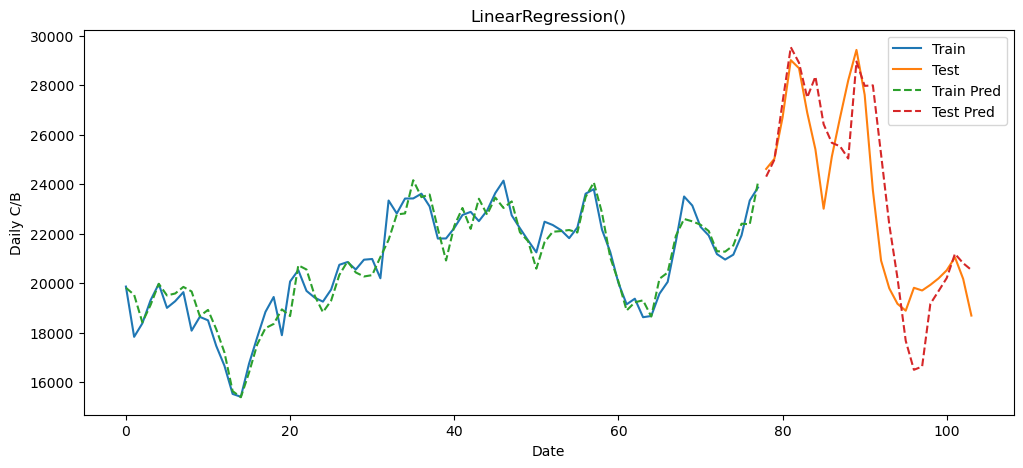

In [237]:
from sklearn.linear_model import LinearRegression

y_train, y_test, y_pred = eval_on_features_own(X_owned, y_owned, n_train, LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X_owned, y_owned, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('Train Score : ', lr.score(X_train, y_train),', ','Test Score : ', lr.score(X_test, y_test))

In [207]:
show_reg_result(y_test,y_pred)

Max Error:  2398.894
Mean Absolute Error:  822.369
Root Mean Squared Error:  1086.122
R-Squared:  0.843


### 3-2) LGBMRegressor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 28
[LightGBM] [Info] Start training from score 20790.346154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

(0.9283967830157059, 0.5836586386164302)

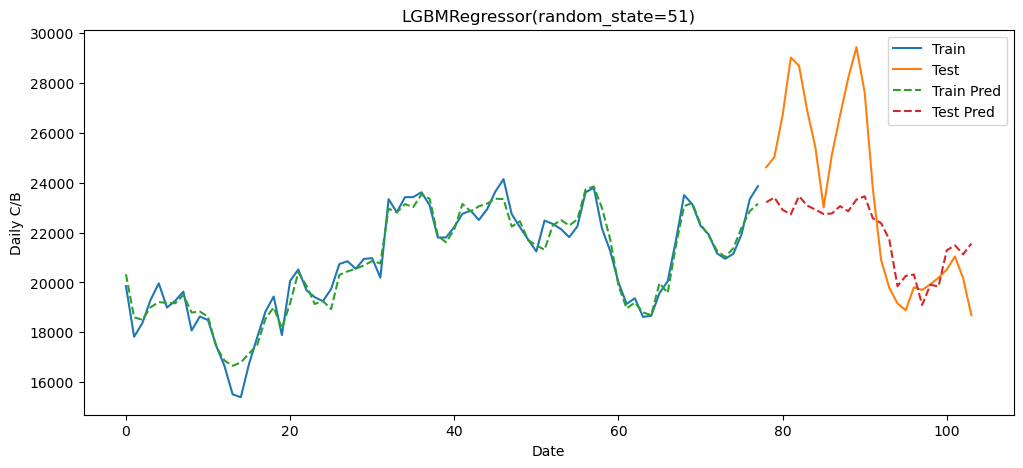

In [238]:
lgbm = LGBMRegressor(random_state=51)
y_train, y_test, y_pred = eval_on_features_own(X_owned, y_owned, n_train, lgbm)

X_train, X_test, y_train, y_test = train_test_split(X_owned, y_owned, random_state=52)

lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)

lgbm.score(X_train, y_train), lgbm.score(X_test, y_test)

In [215]:
show_reg_result(y_test,y_pred)

Max Error:  3612.571
Mean Absolute Error:  1432.398
Root Mean Squared Error:  1753.225
R-Squared:  0.584


### 3-3) RandomForest

(0.9728528521451416, 0.5643484347917285)

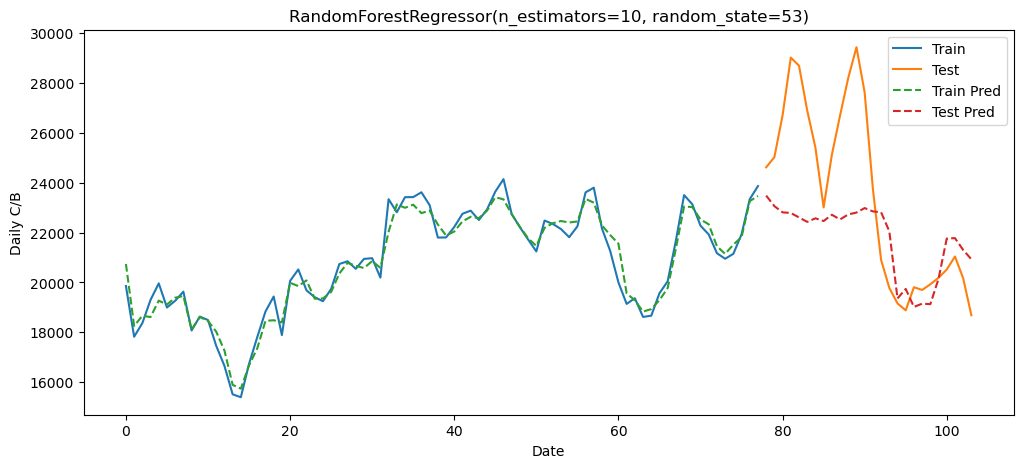

In [239]:
rf = RandomForestRegressor(n_estimators=10, random_state=53)
y_train, y_test, y_pred = eval_on_features_own(X_owned, y_owned, n_train, rf)

X_train, X_test, y_train, y_test = train_test_split(X_owned, y_owned,  random_state=54)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf.score(X_train, y_train), rf.score(X_test, y_test)

In [217]:
show_reg_result(y_test,y_pred)

Max Error:  3414.3
Mean Absolute Error:  1075.731
Root Mean Squared Error:  1415.468
R-Squared:  0.564


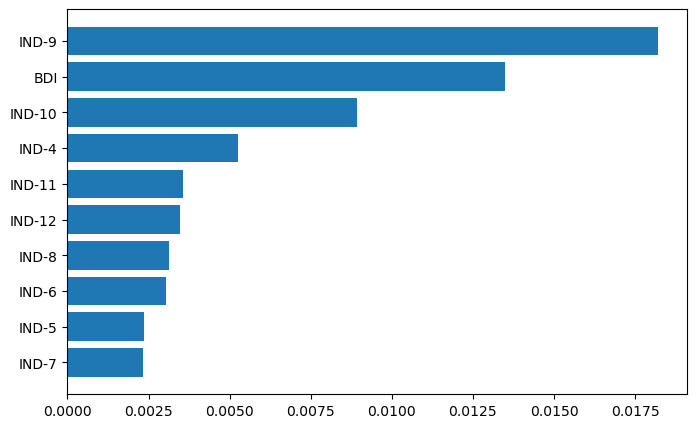

In [218]:
plot_feature_weight(X_owned.columns, rf.feature_importances_, N=10)

### 3-4) SVM

In [219]:
from sklearn.svm import LinearSVR, SVR

svm = LinearSVR(epsilon=1.0, random_state=42)
#svm = SVR(kernel='poly', gamma='auto', degree=2, C=0.001, epsilon=0.5)

X_train, X_test, y_train, y_test = train_test_split(X_owned, y_owned,  random_state=61)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

svm.score(X_train, y_train), svm.score(X_test, y_test)

(0.9297172183827065, 0.7732477249411547)

In [220]:
show_reg_result(y_test,y_pred)

Max Error:  2869.063
Mean Absolute Error:  759.551
Root Mean Squared Error:  991.168
R-Squared:  0.773


#
# 4. 모델 테스트 (용선)

In [221]:
df_tc = data_tc.copy()

### * 훈련 데이터/테스트 데이터를 통한 시각화 Function

In [222]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def eval_on_features_tc(features, target, n_train, model):
    
    X = df_tc.index.astype("int64").values.reshape(-1, 1)
    xticks = pd.date_range(start=df_tc.index.min(), end=df_tc.index.max(), freq='M') 
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle=False)
    
    #print(n_train, X_train.shape, X_test)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    plt.figure(figsize=(12, 5))

    # Create a consistent range for the x-axis based on the length of y_train
    x_range = range(len(y_train))
    
    plt.plot(x_range, y_train, label="Train")
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, '-', label="Test")
    plt.plot(x_range, y_pred_train, '--', label="Train Pred")
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred, '--', label="Test Pred")
    
    plt.legend(loc='best')
    plt.title(str(model))  # Convert model to string
    plt.xlabel("Date")
    plt.ylabel("Daily C/B")
    
    return y_train, y_test, y_pred

In [223]:
X_tc   = df_tc.drop('DAY_CB', axis=1)
y_hire = df_tc.DAY_HIRE
y_tc   = df_tc.DAY_CB

n_train = 0.75

X_tc.shape, y_hire.shape, y_tc.shape

((92, 44), (92,), (92,))

### 4-1) LinearRegression

(0.9985684748526757, 0.965360689844389)

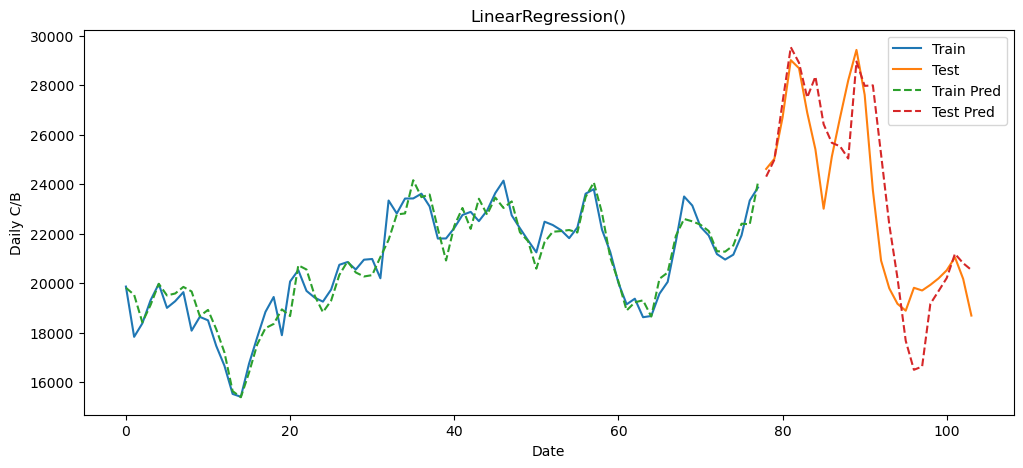

In [240]:
from sklearn.linear_model import LinearRegression

y_train, y_test, y_pred = eval_on_features_tc(X_owned, y_owned, n_train, LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X_tc, y_tc, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

lr.score(X_train, y_train), lr.score(X_test, y_test)

In [25]:
show_reg_result(y_test,y_pred)

Max Error:  2238.191
Mean Absolute Error:  967.219
Root Mean Squared Error:  1116.792
R-Squared:  0.965


### 4-2) LGBMRegressor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 28
[LightGBM] [Info] Start training from score 20790.346154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

(0.9485963337310512, 0.8595308420074124)

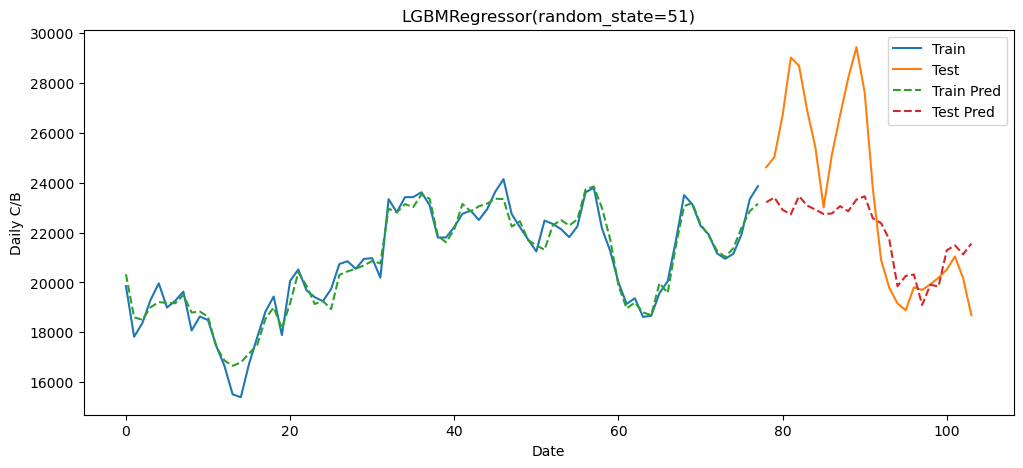

In [241]:
lgbm = LGBMRegressor(random_state=51)
y_train, y_test, y_pred = eval_on_features_tc(X_owned, y_owned, n_train, lgbm)

X_train, X_test, y_train, y_test = train_test_split(X_tc, y_tc, random_state=52)

lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)

lgbm.score(X_train, y_train), lgbm.score(X_test, y_test)

In [227]:
show_reg_result(y_test,y_pred)

Max Error:  7082.433
Mean Absolute Error:  2454.027
Root Mean Squared Error:  3072.417
R-Squared:  0.86


### 4-3) RandomForest

(0.9890700841426956, 0.800493271796804)

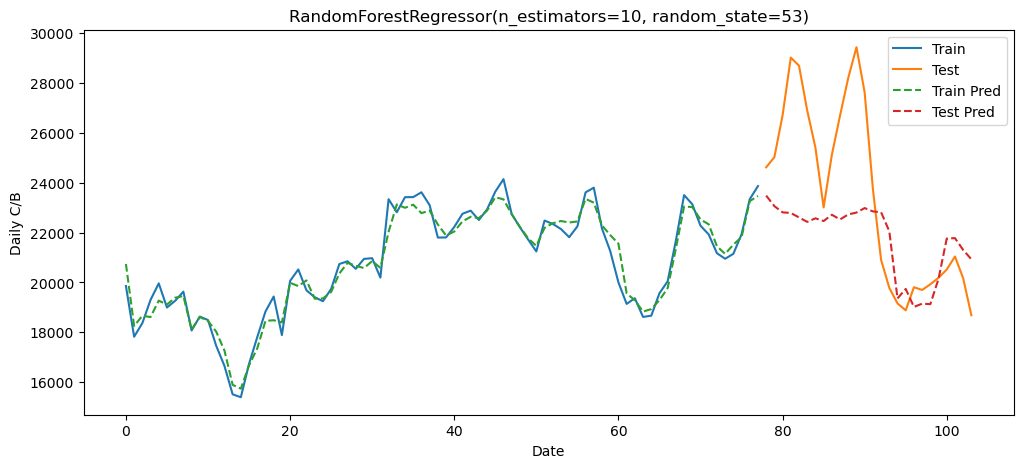

In [242]:
rf = RandomForestRegressor(n_estimators=10, random_state=53)
y_train, y_test, y_pred = eval_on_features_tc(X_owned, y_owned, n_train, rf)

X_train, X_test, y_train, y_test = train_test_split(X_tc, y_tc, random_state=54)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf.score(X_train, y_train), rf.score(X_test, y_test)

In [229]:
show_reg_result(y_test,y_pred)

Max Error:  9327.2
Mean Absolute Error:  2129.448
Root Mean Squared Error:  3348.818
R-Squared:  0.8


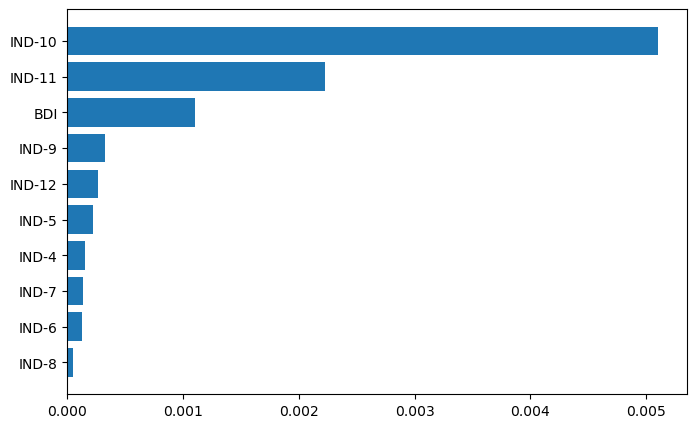

In [230]:
plot_feature_weight(X_tc.columns, rf.feature_importances_, N=10)

### 4-4) SVM

(0.9877084469338365, 0.9688507337936992)

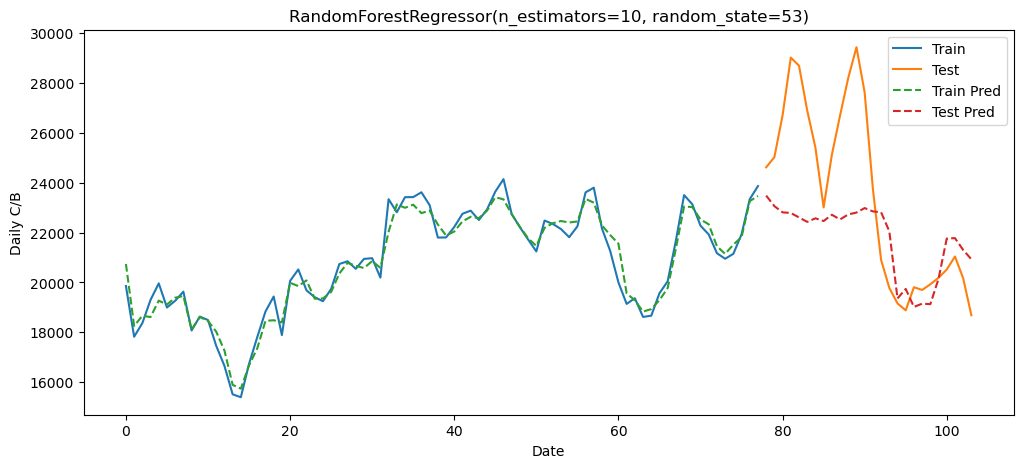

In [243]:
from sklearn.svm import LinearSVC

svm = LinearSVR(epsilon=1.0, random_state=42)
y_train, y_test, y_pred = eval_on_features_tc(X_owned, y_owned, n_train, rf)

X_train, X_test, y_train, y_test = train_test_split(X_tc, y_tc,  random_state=61)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

svm.score(X_train, y_train), svm.score(X_test, y_test)

In [232]:
show_reg_result(y_test,y_pred)

Max Error:  2918.677
Mean Absolute Error:  718.218
Root Mean Squared Error:  1002.511
R-Squared:  0.969


# 5. PolynorminalFeatures

In [244]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_owned_poly = poly.fit_transform(X_owned)
X_tc_poly    = poly.fit_transform(X_tc)

In [234]:
X_owned_poly.shape

(104, 434)

### 5-1) LinearRegression

### - 사선

(1.0, 0.07687209608704648)

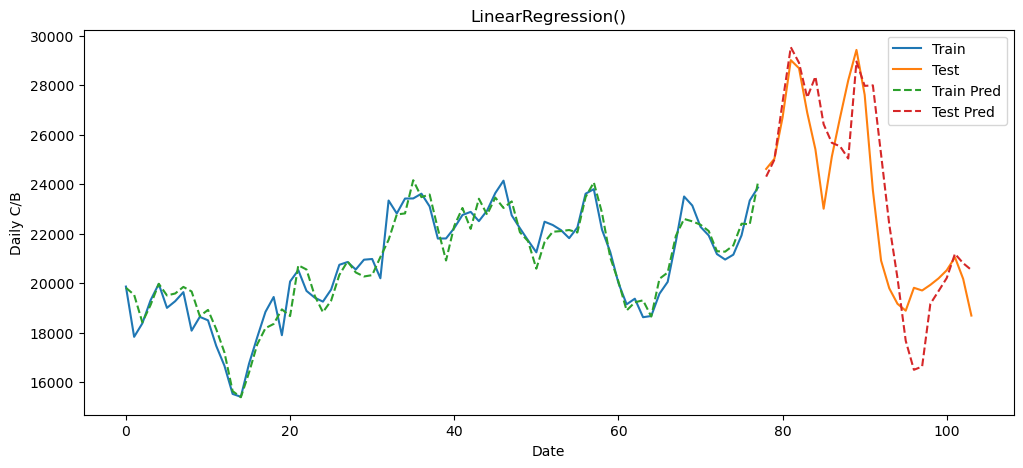

In [245]:
from sklearn.linear_model import LinearRegression

y_train, y_test, y_pred = eval_on_features_own(X_owned, y_owned, n_train, LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X_owned_poly, y_owned, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

lr.score(X_train, y_train), lr.score(X_test, y_test)

In [246]:
show_reg_result(y_test,y_pred)

Max Error:  6810.958
Mean Absolute Error:  2042.3
Root Mean Squared Error:  2635.509
R-Squared:  0.077


### - 용선

(1.0, 0.8895014431337466)

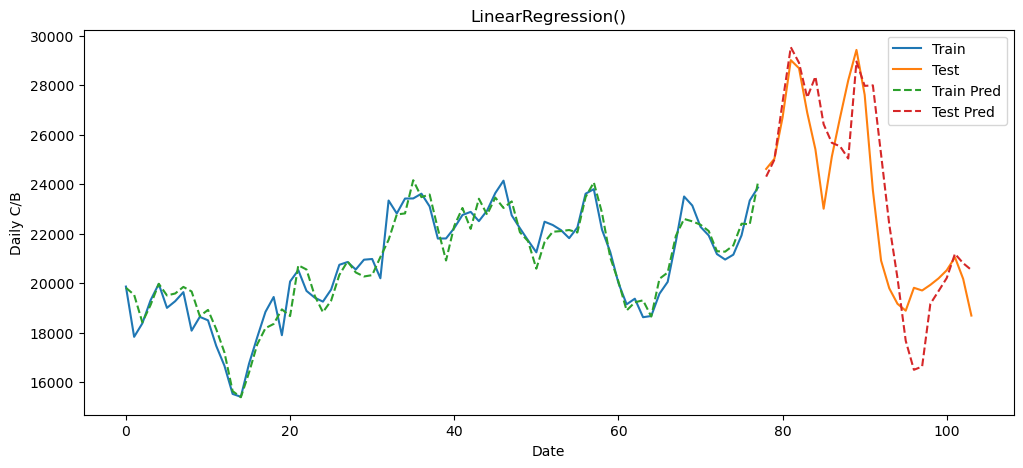

In [247]:
y_train, y_test, y_pred = eval_on_features_tc(X_owned, y_owned, n_train, LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X_tc_poly, y_tc, random_state=2)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

lr.score(X_train, y_train), lr.score(X_test, y_test)

In [248]:
show_reg_result(y_test,y_pred)

Max Error:  7161.778
Mean Absolute Error:  1478.743
Root Mean Squared Error:  2241.231
R-Squared:  0.89


### 5-2) RandomForest

### - 사선

(0.9611233812953428, 0.6123858810730165)

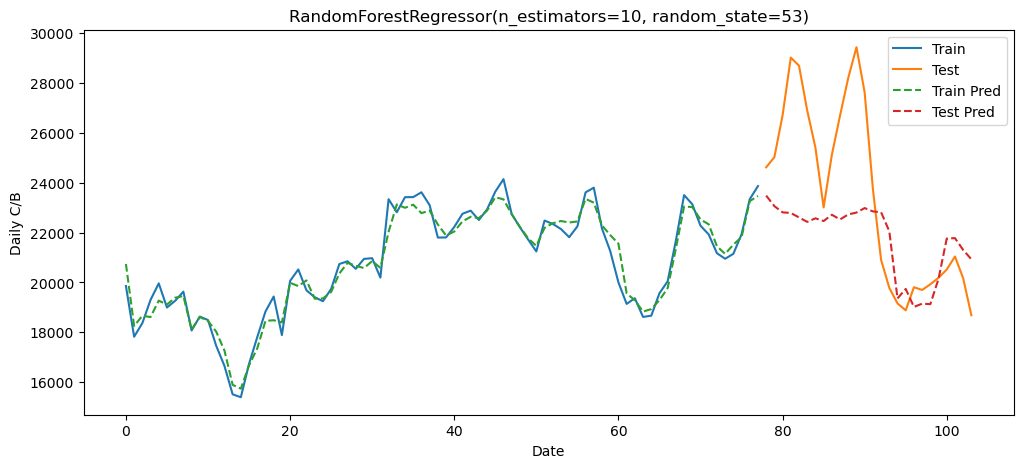

In [249]:
rf = RandomForestRegressor(n_estimators=10, random_state=53)
y_train, y_test, y_pred = eval_on_features_own(X_owned, y_owned, n_train, rf)

X_train, X_test, y_train, y_test = train_test_split(X_owned_poly, y_owned,  random_state=54)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf.score(X_train, y_train), rf.score(X_test, y_test)

### - 용선

(0.9907078277125559, 0.9177863389904607)

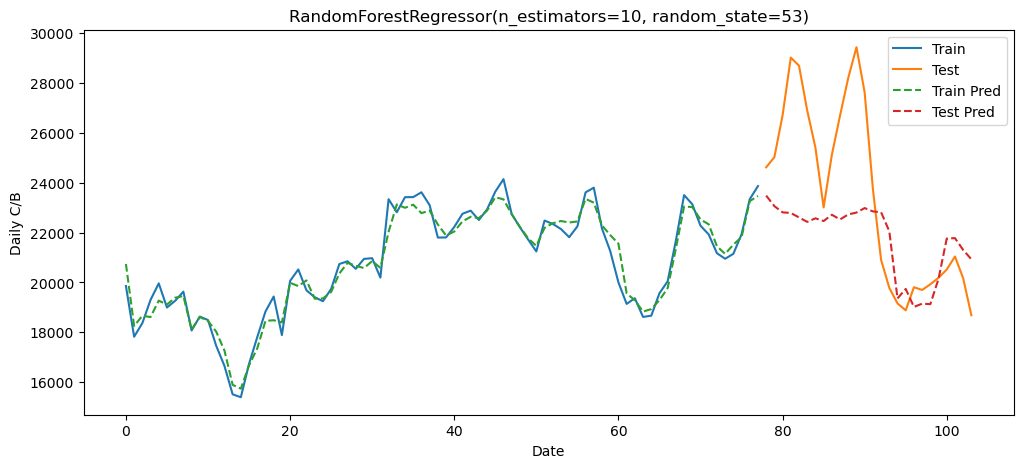

In [250]:
rf = RandomForestRegressor(n_estimators=10, random_state=53)
y_train, y_test, y_pred = eval_on_features_tc(X_owned, y_owned, n_train, rf)

X_train, X_test, y_train, y_test = train_test_split(X_tc_poly, y_tc,  random_state=54)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf.score(X_train, y_train), rf.score(X_test, y_test)

In [175]:
show_reg_result(y_test,y_pred)

Max Error:  5674.9
Mean Absolute Error:  1437.622
Root Mean Squared Error:  2149.734
R-Squared:  0.918


### 5-3) SVM

### - 사선

(0.9297172183827065, 0.7732477249411547)

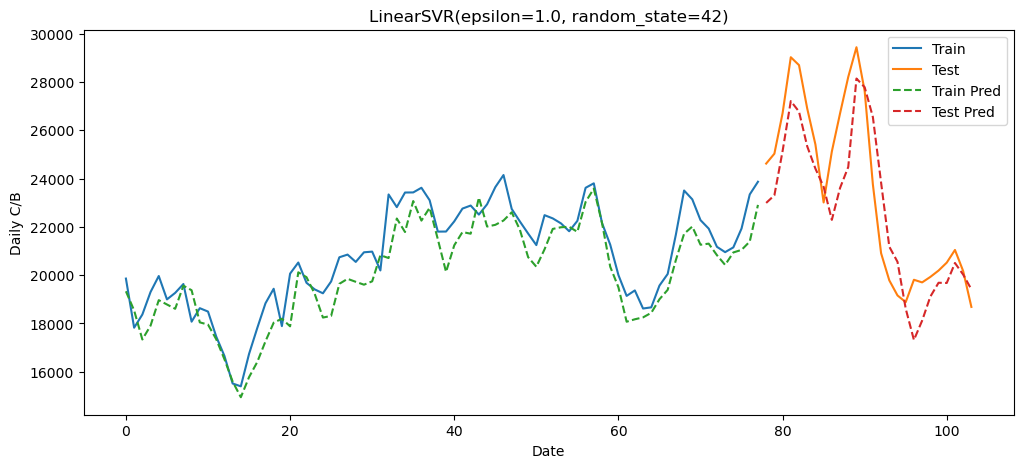

In [251]:
from sklearn.svm import LinearSVR, SVR

svm = LinearSVR(epsilon=1.0, random_state=42)
y_train, y_test, y_pred = eval_on_features_own(X_owned, y_owned, n_train, svm)
#svm = SVR(kernel='poly', gamma='auto', degree=2, C=0.001, epsilon=0.5)

X_train, X_test, y_train, y_test = train_test_split(X_owned, y_owned,  random_state=61)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

svm.score(X_train, y_train), svm.score(X_test, y_test)

### - 용선

(0.9964862630859536, 0.9813208417721054)

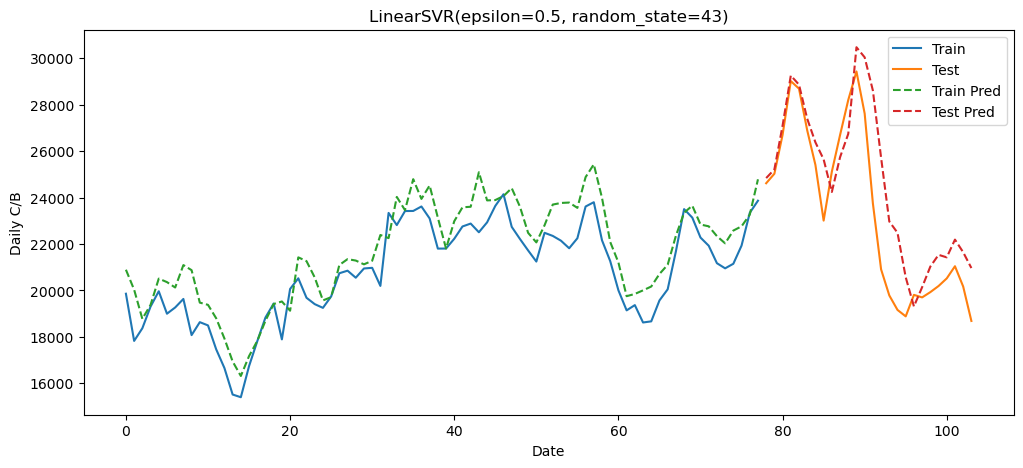

In [252]:
from sklearn.svm import LinearSVR

svm = LinearSVR(epsilon=0.5, random_state=43)
y_train, y_test, y_pred = eval_on_features_tc(X_owned, y_owned, n_train, svm)

X_train, X_test, y_train, y_test = train_test_split(X_tc, y_tc,  random_state=61)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

svm.score(X_train, y_train), svm.score(X_test, y_test)

In [177]:
show_reg_result(y_test,y_pred)

Max Error:  2441.37
Mean Absolute Error:  573.952
Root Mean Squared Error:  776.325
R-Squared:  0.981


# 6. GridSearchCV (교차 검증 + 매개변수 최적화)
- 매개 변수
  1) best_params_ : 교차 검증으로 선택된 최적의 매개 변수
  2) best_score_ : best_params_가 적용된 교차 검증 정확도

In [253]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris


X_train, X_test, y_train, y_test = train_test_split(X_tc, y_tc, random_state=61)

para_grid = {'epsilon' : [0.5, 1.0, 1.5]}

grid_search = GridSearchCV(LinearSVR(), para_grid, cv=3, return_train_score=True)
grid_search.fit(X_train, y_train)

grid_search.score(X_test, y_test)

0.9628994697342145

In [254]:
grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

({'epsilon': 1.0}, 0.983423353166831, LinearSVR(epsilon=1.0))

# 7. K-Fold 교차 검증 (모델의 일반화 성능 평가)
- 분류 : 계층별 K-Fold 교차 검증 > K-Fold 교차 검증
- 회귀 : K-Fold 교차 검증
- 매개 변수
  1) cv : Fold 수 지정

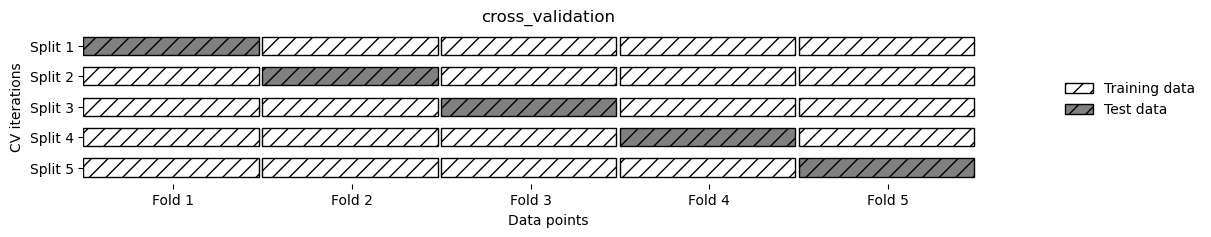

In [5]:
mglearn.plots.plot_cross_validation()

### - 사선

In [255]:
from sklearn.model_selection import KFold, cross_val_score

lr = LinearRegression()

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
score = cross_val_score(lr, X_owned, y_owned, cv=kfold)
print(score, ', Average : ', score.mean())

[0.72068788 0.92178383 0.84757491 0.76586382 0.86676697] , Average :  0.8245354820717627


### - 용선

In [256]:
from sklearn.model_selection import KFold, cross_val_score

svm = LinearSVR(epsilon=0.5, random_state=43)

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
score = cross_val_score(svm, X_tc, y_tc, cv=kfold)
print(score, ', Average : ', score.mean())

[0.99217894 0.98463042 0.90944776 0.97566739 0.97147478] , Average :  0.9666798587910052


# 8. 사업계획 vs. 실적 vs. Predict

### - 사선